In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from dot_density_mapping import gen_points_in_gdf_polys, gen_random_points_poly
import pickle
from scipy.stats import spearmanr
import adjustText

%matplotlib inline

In [2]:
def set_zoom(ax, ref_layer, buffer = 0):
    '''Sets the zoom of a map to the extent of the reference layer.
    ax is a matplotlib axis used for plotting a map, ref_layer is a geodataframe, buffer is an additional margin around 
    the extent of the reference layer (in units of the CRS of the reference layer).'''
    minx, miny, maxx, maxy = ref_layer.total_bounds
    minx -= buffer
    maxx += buffer
    miny -= buffer
    maxy += buffer
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

### Load Geodata

In [3]:
with open('../90 Data/compiled secondary data/msoas', 'rb') as infile:
    msoas = pickle.load(infile)
with open('../90 Data/compiled secondary data/londontube', 'rb') as infile:
    londontube = pickle.load(infile)
with open('../90 Data/compiled secondary data/londonrail', 'rb') as infile:
    londonrail = pickle.load(infile)

### Figure 1: GLA Map

(503574.18796895276, 561956.6879520521, 155850.7979227482, 200933.60890773044)

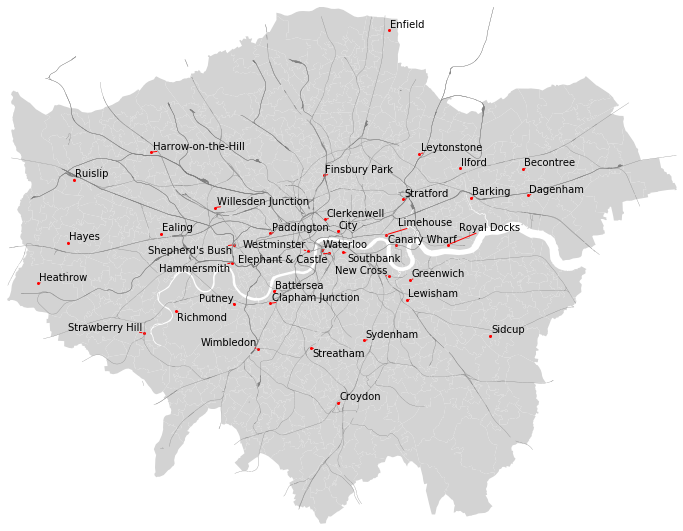

In [4]:
# generate labelling points in msoa boundaries
msoas['label_point'] = msoas['geometry'].representative_point()

# set labels of mentioned places
msoas['Label'] = ''
msoas.loc['E02000726','Label'] = 'Stratford'
msoas.loc['E02000001','Label'] = 'City'
msoas.loc['E02000979','Label'] = 'Westminster'
msoas.loc['E02000812','Label'] = 'Southbank'
msoas.loc['E02006854','Label'] = 'Canary Wharf'
msoas.loc['E02000524','Label'] = 'Heathrow'
msoas.loc['E02000279','Label'] = 'Enfield'
msoas.loc['E02000886','Label'] = 'Limehouse'
msoas.loc['E02000014','Label'] = 'Dagenham'
msoas.loc['E02000575','Label'] = 'Clerkenwell'
msoas.loc['E02000375','Label'] = "Shepherd's Bush"
msoas.loc['E02006802','Label'] = 'Elephant & Castle'
msoas.loc['E02000213','Label'] = 'Croydon'
msoas.loc['E02000384','Label'] = 'Hammersmith'
msoas.loc['E02000455','Label'] = 'Harrow-on-the-Hill'
msoas.loc['E02000558','Label'] = 'Finsbury Park'
msoas.loc['E02000649','Label'] = 'Streatham'
msoas.loc['E02000664','Label'] = 'Lewisham'
msoas.loc['E02000779','Label'] = 'Ilford'
msoas.loc['E02000016','Label'] = 'Barking'
msoas.loc['E02000915','Label'] = 'Leytonstone'
msoas.loc['E02006798','Label'] = 'New Cross'
msoas.loc['E02000090','Label'] = 'Sidcup'
msoas.loc['E02006801','Label'] = 'Waterloo'
msoas.loc['E02000691','Label'] = 'Wimbledon'
msoas.loc['E02000975','Label'] = 'Paddington'
msoas.loc['E02000502','Label'] = 'Ruislip'
msoas.loc['E02000933','Label'] = 'Putney'
msoas.loc['E02000791','Label'] = 'Richmond'
msoas.loc['E02000799','Label'] = 'Strawberry Hill'
msoas.loc['E02000926','Label'] = 'Battersea'
msoas.loc['E02000256','Label'] = 'Ealing'
msoas.loc['E02000520','Label'] = 'Hayes'
msoas.loc['E02000685','Label'] = 'Sydenham'
msoas.loc['E02000005','Label'] = 'Becontree'
msoas.loc['E02000750','Label'] = 'Royal Docks'
msoas.loc['E02006931','Label'] = 'Greenwich'
msoas.loc['E02000934','Label'] = 'Clapham Junction'
msoas.loc['E02000123','Label'] = 'Willesden Junction'

# plot map
label_points = gpd.GeoDataFrame({'geometry': msoas[msoas['Label'] != '']['geometry'].representative_point()})

fig01 = plt.figure(figsize = (12,10.6))
ax01_01 = fig01.add_subplot(111)
set_zoom(ax01_01, msoas)
msoas.plot(ax = ax01_01, color = 'lightgrey')
londontube.plot(ax = ax01_01, color = 'grey', linewidth = .3)
londonrail.plot(ax = ax01_01, color = 'grey', linewidth = .3)
label_points.plot(ax = ax01_01, color = 'red', markersize = 4)

labels = [ax01_01.text(label[1][2].x,
                       label[1][2].y,
                       label[1][3],
                       horizontalalignment = 'center') for label in msoas.iterrows() if not label[1][3] == '']
adjustText.adjust_text(labels, arrowprops = dict(arrowstyle = '-', color = 'red'))
plt.axis('off')

### Figure 3: Distribution of Population and Jobs

In [5]:
with open('../90 Data/compiled secondary data/popcounts', 'rb') as infile:
    popcounts = pickle.load(infile)
with open('../90 Data/compiled secondary data/jobcounts', 'rb') as infile:
    jobcounts = pickle.load(infile)

In [6]:
plottingsettings = {'jobcounts': {'data': jobcounts['Jobs_Total'], 'type': 'Jobs'},
                    'popcounts': {'data': popcounts['Pop_WorkingAge'], 'type': 'Working Age Population'}}
plottingdata = []

# generate randomly located point per number of counts
count_per_point = 1000
currentgeom = msoas.geometry.copy()
for dataset in plottingsettings.keys():
    currentpoints = gpd.GeoDataFrame(gen_points_in_gdf_polys(currentgeom, plottingsettings[dataset]['data'], points_per_value = count_per_point))
    currentpoints['type'] = plottingsettings[dataset]['type']
    #currentblackoutarea = currentpoints.buffer(50).unary_union # additional code to avoid points located too close to each other, but runs slowly
    #currentgeom = currentgeom.difference(currentblackoutarea)
    plottingdata.append(currentpoints)
plottingdata = gpd.GeoDataFrame(pd.concat(plottingdata))

Distribution of Population and Jobs
1 point per 1000


(503574.18796895276, 561956.6879520521, 155850.7979227482, 200933.60890773044)

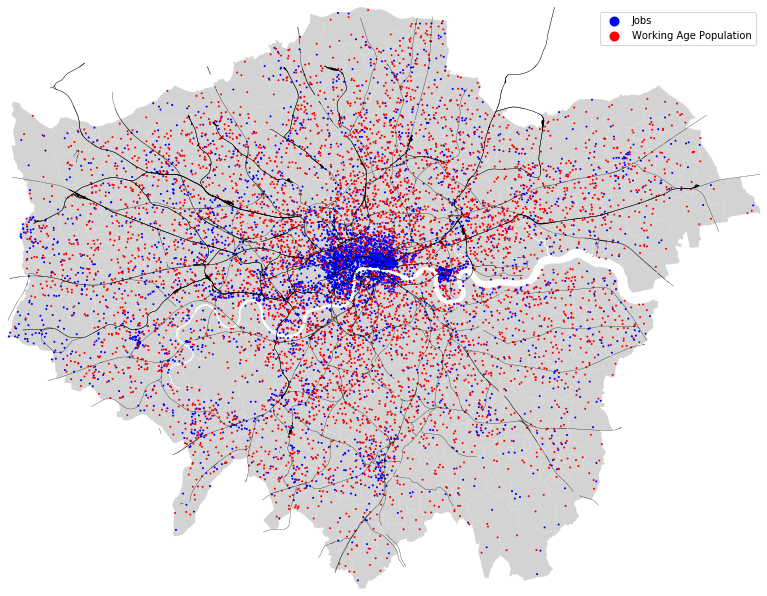

In [7]:
# plot map
fig01 = plt.figure(figsize = (13.5,12))
ax01_01 = fig01.add_subplot(111)
set_zoom(ax01_01, msoas) # setting zoom
msoas.plot(color = 'lightgrey', ax = ax01_01) # basemap
plottingdata.plot(column = 'type', ax = ax01_01, markersize = 1, categorical = True, cmap = 'bwr', legend = True) # points
londontube.plot(ax = ax01_01, linewidth = .3, color = 'black') # rail lines
londonrail.plot(ax = ax01_01, linewidth = .3, color = 'black')
print('Distribution of Population and Jobs\n1 point per ' + str(count_per_point))
plt.axis('off')

### Figure 11: Indicators of Disadvantage per MSOA

In [8]:
with open('../90 Data/compiled secondary data/hhincome_mean', 'rb') as infile:
    hhincome_mean = pickle.load(infile)
with open('../90 Data/compiled secondary data/hhpovrate', 'rb') as infile:
    hhpovrate = pickle.load(infile)
with open('../90 Data/compiled secondary data/unemploymentrate', 'rb') as infile:
    unemploymentrate = pickle.load(infile)
with open('../90 Data/compiled secondary data/imd_msoa', 'rb') as infile:
    imd_msoa = pickle.load(infile)

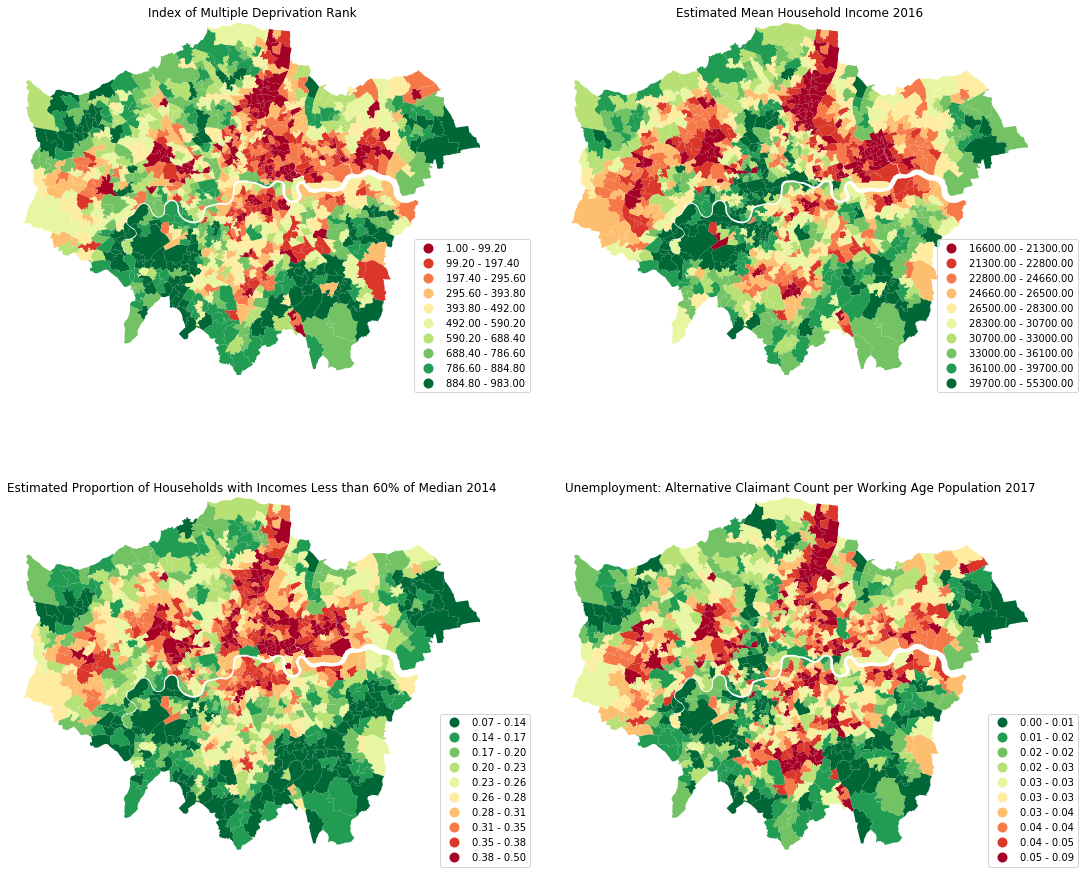

In [9]:
plottingsettings = {'Index of Multiple Deprivation Rank': {'data': imd_msoa, 'column': 'Index of Multiple Deprivation (IMD) Rank', 'colour': 'RdYlGn'},
                    'Estimated Mean Household Income 2016': {'data': hhincome_mean, 'column': 'Est Mean HH Income', 'colour': 'RdYlGn'},
                    'Estimated Proportion of Households with Incomes Less than 60% of Median 2014': {'data': hhpovrate, 'column': 'PC Poor Households', 'colour': 'RdYlGn_r'},
                    'Unemployment: Alternative Claimant Count per Working Age Population 2017': {'data': unemploymentrate, 'column': 'Unemployment Rate', 'colour': 'RdYlGn_r'}
                   }

# plot figure
fig03 = plt.figure(figsize = (18,16))
i = 1
for dataset in plottingsettings.keys():
    ax03 = fig03.add_subplot(2,2,i)
    set_zoom(ax03, msoas) # setting zoom
    plottingdata = msoas.join(plottingsettings[dataset]['data'])
    plottingdata.plot(column = plottingsettings[dataset]['column'], ax = ax03, scheme = 'quantiles', k = 10, 
                      cmap = plottingsettings[dataset]['colour'], legend = True)
    legend03 = ax03.get_legend()
    legend03.set_bbox_to_anchor((1.12,.4))
    plt.axis('off')
    plt.title(dataset)
    i += 1

In [10]:
# spearman rank correlation between deprivation indicators
for data in [hhincome_mean['Est Mean HH Income'], hhpovrate['PC Poor Households'], unemploymentrate['Unemployment Rate']]:
    print('IMD Rank &', data.name, spearmanr(imd_msoa['Index of Multiple Deprivation (IMD) Rank'], data)[0])


IMD Rank & Est Mean HH Income 0.8124213607813265
IMD Rank & PC Poor Households -0.8607721113390158
IMD Rank & Unemployment Rate -0.8991868703733354
